# Time Series Analysis and Forecasting in Python

#### Author: Christian Thieme
#### Date: 5-07-2020
#### DATA607: Final Project 

# Introduction

The purpose of this project is to dive in and explore time series predictive modeling in Python. As part of this project, I will also explore the statistical underpinnings relevant to time series analysis and building a predictive model. 

The data set we will be looking at comes from the "Store Item Demand Forecasting" Kaggle Competition. The data set includes 5 years of store-item sales data and we are asked to predict 3 months of sales for 50 different items across 10 different stores. The link to the competition can be found [here](https://www.kaggle.com/c/demand-forecasting-kernels-only). The training and test data sets can be found on my GitHub, [here](https://github.com/christianthieme/MSDS-DATA607/tree/master/Final%20Project%20-%20Time%20Series%20Analysis%20in%20Python). 

This project will be my first introduction to time series predictive modeling, and the focus will be on learning and understanding the different aspects of time series analysis and classic model creation as opposed to selecting an algorithm to provide a top score on Kaggle. In fact, top scorers in this competition are using gxboost and neural networks, not classic time series models. In addition, this will give me the opportunity to enter my first Kaggle competition.

To begin exploring the data, let's load the packages we will be using:

In [214]:
import numpy as np
import pandas as pd 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import lag_plot
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
import holidays
import re
from pylab import rcParams

Now that we've loaded the necessary packages, let's load our training and test data. 

In [445]:
train = pd.read_csv("https://raw.githubusercontent.com/christianthieme/MSDS-DATA607/master/Final%20Project%20-%20Time%20Series%20Analysis%20in%20Python/train.csv", index_col= 'date', parse_dates= True)
test = pd.read_csv("https://raw.githubusercontent.com/christianthieme/MSDS-DATA607/master/Final%20Project%20-%20Time%20Series%20Analysis%20in%20Python/test.csv", index_col= 'date', parse_dates= True)

To make sure we are performing all the same transformations of the data on both the training and test data sets, we will combine the data sets and indicate which rows are training data and test data. Lastly, we'll append the data sets together. 

In [446]:
train['train_or_test'] = 'TRAIN'
test['train_or_test'] = 'TEST'

In [447]:
df = train.append(test, sort=False)
df.head()

,store,item,sales,train_or_test,id
date,,,,,
2013-01-01,1,1,13.0,TRAIN,NaN
2013-01-02,1,1,11.0,TRAIN,NaN
2013-01-03,1,1,14.0,TRAIN,NaN
2013-01-04,1,1,13.0,TRAIN,NaN
2013-01-05,1,1,10.0,TRAIN,NaN


As a quick note, the test data set contains an "id" column that Kaggle uses to identify your predicted value vs their actual value. This column does not exist in the training set and so will be null. Additionally, as you would expect, the test data set does not have sales values as that is what we are trying to predict. It only contains the date, store #, item #, and id columns. 

## Analysis

When building predictive models, especially a time series model, it is important that we don't have NULL values in our data. Let's run a quick check over the training data set and make sure that we don't see any nulls besides in the "id" column. 

In [165]:
df[df['train_or_test']=="TRAIN"].isnull().sum()

store                 0
item                  0
sales                 0
train_or_test         0
id               913000
dtype: int64

Now let's see if we can get a feel for the data. Let's look at the trend of sales for the 10 stores over the length of the 5 years of data we are given. We will look at this aggregating the data at the weekly level.

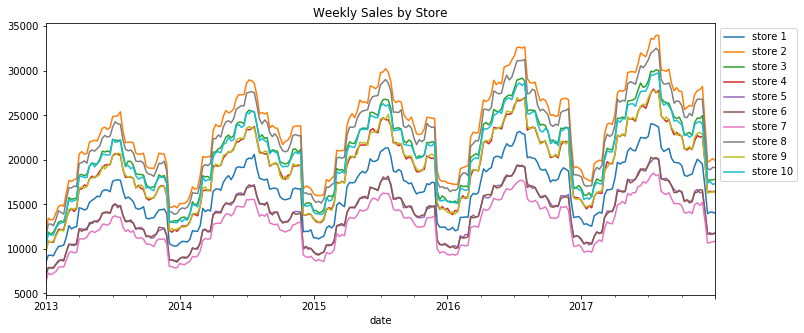

In [166]:
for i in range(1,11): 
    ax = df[(df['store']==i) & (df['train_or_test']=="TRAIN")]['sales'].resample('W').sum().rename('store {}'.format(i)).plot(title = "Weekly Sales by Store", 
                                                                                           figsize = (12,5), legend = True)
ax.legend(bbox_to_anchor=(1, 1))

Right away we notice something odd. All 10 stores show the same trend and seasonality, just at differing levels of magnitude. So this tells us one of two things: either this data set is a curated data set, or it comes from a unique and seasonal industry with somewhat limited product offerings that don't often change. My gut tells me trends like this don't often occur out in the wild. Below, we'll look at the same view, but at a monthly level to see if we can smooth out some of the variability. 

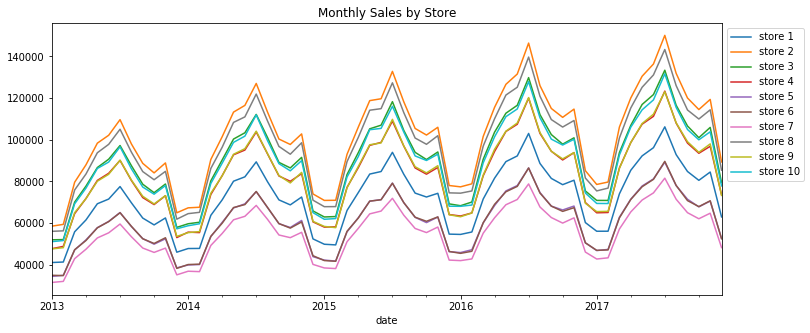

In [167]:
for i in range(1,11): 
    ax = df[(df['store']==i) & (df['train_or_test']=="TRAIN")]['sales'].resample('M').sum().rename('store {}'.format(i)).plot(title = "Monthly Sales by Store", 
                                                                                          figsize = (12,5), legend = True)
ax.legend(bbox_to_anchor=(1, 1))

Looking at the above chart, we can see that there is some very clear seasonality that repeats year after year. We can also see a slight upward trend each year, meaning that sales are growing year over year. Next, let's smooth this data out even further and take a look at it at a yearly level.

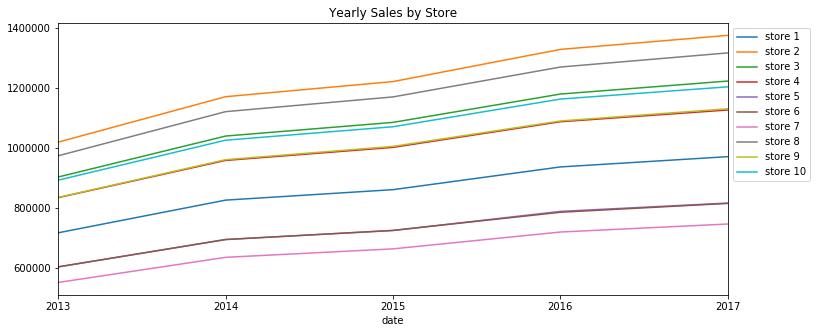

In [168]:
for i in range(1,11): 
    ax = df[(df['store']==i) & (df['train_or_test']=="TRAIN")]['sales'].resample('Y').sum().rename('store {}'.format(i)).plot(title = "Yearly Sales by Store", 
                                                                                          figsize = (12,5), legend = True)
ax.legend(bbox_to_anchor=(1, 1))

There is a very clear upward trend in the sales each year, but we can still see the yearly seasonality at play. Now that we've got a high-level understanding of the data at the store level, let's take this one step further and look at the trend in sales at the item level. We'll start by looking at each item's sales at a weekly grain. 

*Note: legends will not be shown at the item level as there are 50 items. The purpose of these views is to observe general trends and seasonality, not to deep dive on an individual product.* 

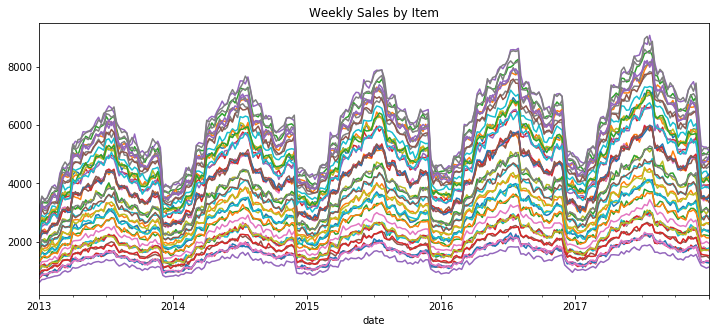

In [169]:
for i in range(1,51): 
    df[(df['item']==i) & (df['train_or_test']=="TRAIN")]['sales'].resample('W').sum().plot(title = "Weekly Sales by Item", figsize = (12,5))

At the item level, we see a very similar pattern to what we saw above with the stores, where each item has a very similar trend and seasonality, but just at different levels of magnitude. Once again, let's smooth this data and look at it at a monthly level. 

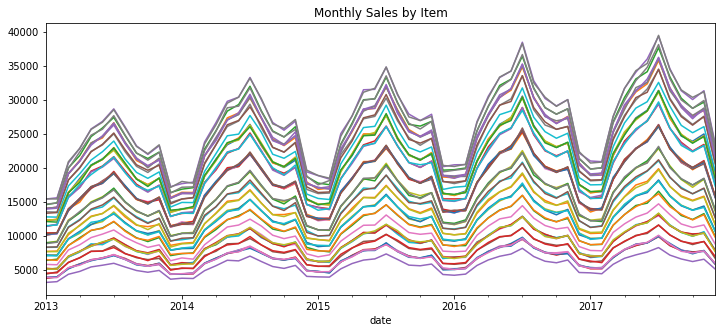

In [170]:
for i in range(1,51): 
    df[(df['item']==i) & (df['train_or_test']=="TRAIN")]['sales'].resample('M').sum().plot(title = "Monthly Sales by Item", figsize = (12,5))

One thing we can see at the monthly level is that there are only ~20 items that have different magnitudes in their trends and seasonality. In the chart above, we only see ~20 lines, which means many of the lines are sitting on top of each other. We'll go one step deeper and look at the yearly sales by item. 

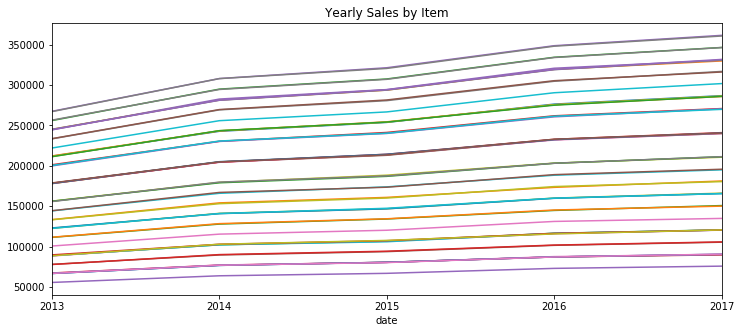

In [171]:
for i in range(1,51): 
    df[(df['item']==i) & (df['train_or_test']=="TRAIN")]['sales'].resample('Y').sum().plot(title = "Yearly Sales by Item", figsize = (12,5))

## Strategy Going Forward

The charts above, while simplistic, provide us with some powerful information. First, we can conclude that, while there are magnitude differences in the sales from different stores and items, the overall trend and seasonality remains fairly consistent from store to store and from item to item. As our objective is to build a predictive model to predict sales for the next 30 days by store by item, we can generalize and say that while there are magnitude differences between these factors, overall trend and seasonality remain fairly consistent from item to item and store to store. Key to building a predictive time series model is understanding the trend, seasonality, stationarity, and autoregressive properties of your data. As these factors seem to remain fairly consistent between items and stores, we can look at an individual item from an individual store and perform our analysis and build a model that we then could apply to the larger population that will still work fairly well for all items at all stores. Let's start by looking at item 1 from store 1:

In [172]:
store_1 = df[(df['store']==1) & (df['item']==1) & (df['train_or_test']=="TRAIN")][['sales']]
store_1.index.freq = 'D'
store_1

,sales
date,
2013-01-01,13.0
2013-01-02,11.0
2013-01-03,14.0
2013-01-04,13.0
2013-01-05,10.0
...,...
2017-12-27,14.0
2017-12-28,19.0
2017-12-29,15.0


### Performing Time Series Analysis with a Purpose

Our purpose at the end of the day is to come up with daily predicted sales values for all 50 items in each of the 10 stores. To do this, we will employ a classic time series forecasting model called SARIMAX. SARIMAX is an ARIMA model (Autoregressive Integrated Moving Average) that allows for Seasonal adjustments (the 'S' in SARIMAX) as well as the addition of exogenous variables (the 'X'). In order to provide the appropriate arguments to the model, we need to do some significant analysis to tease out the data's seasonality, stationarity, and autoregressive properties. We'll explore this in the sections below. However, as we'll see it is often faster, and more accurate to use an automated process to complete this analysis as interpreting the results can often be difficult and is not guaranteed to provide the optimized parameters. 

### Introduction to Error, Trend, and Seasonality Decomposition (ETS)

Time series data often have what are called seasonality and trend components. Understanding these components can be very useful in creating a predictive model. However, in looking at the chart below from store 1 item 1, its hard to tell what is seasonal changes vs trend changes. In general, seasonality is variation in the data that occurs at specific and regular intervals. For example, each year at the end of November and through the month of December you will see the purchase of Christmas trees increase. Trend on the other hand describes a systematic change over time that does not repeat. When I think of trend I think about looking at the Amazon stock price over the last 5 years. While there have been peaks and valleys along the way, there is an overall upward trend. What isn't explained by seasonality and trend, we call error or "noise". Being able to separate these components to analyze them separately is critical to time series analysis. This type of analysis is called ETS Decomposition. 

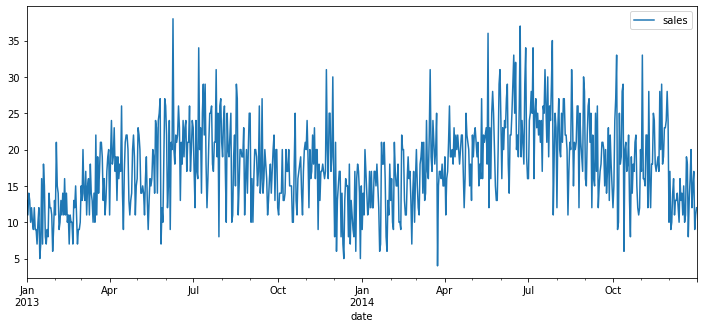

In [173]:
store_1['2013-01-01':'2014-12-31'].plot(legend = True,figsize = (12,5))

As you will see later, understanding these components will help us know which parameters to use when training our predictive model. The miscalculation on one of these parameters can have an enormous effect on your model's ability to fit the data. Let's decompose this data to get an idea for the trend and seasonality: 

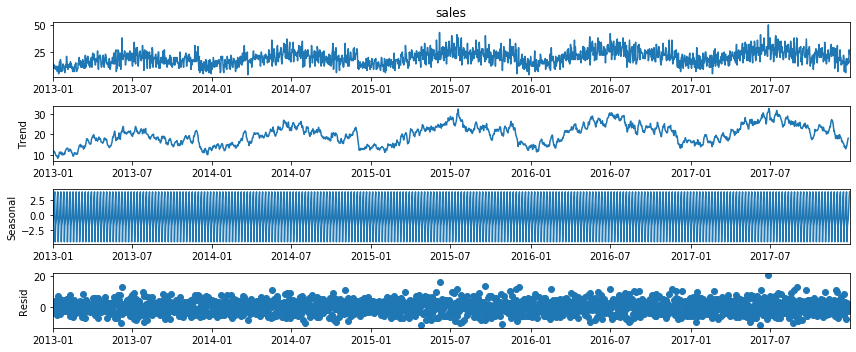

In [118]:
rcParams['figure.figsize'] = 12,5
result = seasonal_decompose(store_1['sales'], model='additive')
result.plot();

Above, when calling the seasonal decompose function, we used an 'additive' model. An additive model is applied when we see a more linear trend and the seasonality and trend are fairly constant. From looking at our charts at the beginning of this project, especially at the yearly plots, I think an additive model fits best here. A 'multiplicative' model is more appropriate when trend is increasing or decreasing at a non-linear rate (exponential or other). In looking at the chart above, the top box shows us the sales value over time, the second box shows the trend component, the third box shows the seasonal component and the fourth box shows the "error" or residuals. We'll take a deeper look at these plots below, particularly the seasonal plot. In the plot above, there is so much seasonality it almost blends together, however, as we enlarge the plot we begin to see the seasonal component:

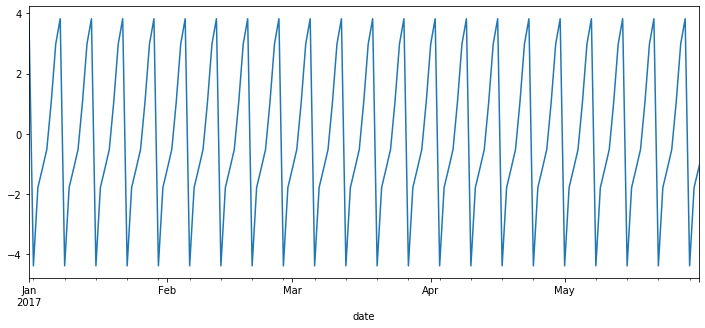

In [113]:
result.seasonal.plot(figsize = (12,5), xlim = ('2017-01-01','2017-05-31'))

Looking at the plot above, we can see that there is a distinct weekly seasonality to this data. This will be a critical input into a predictive model. Having identified our seasonal component, let's move on to trend.

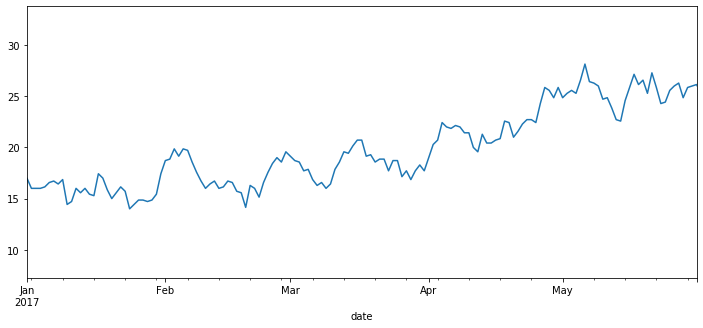

In [116]:
result.trend.plot(figsize = (12,5), xlim = ('2017-01-01','2017-05-31'))

As we saw in the plots earlier, it appears there is a upward trend to this data. Looking at the residuals below, it looks like the residuals are random and evenly spaced, indicating that the function did a good job of decomposing the trend and seasonality from the noise. 

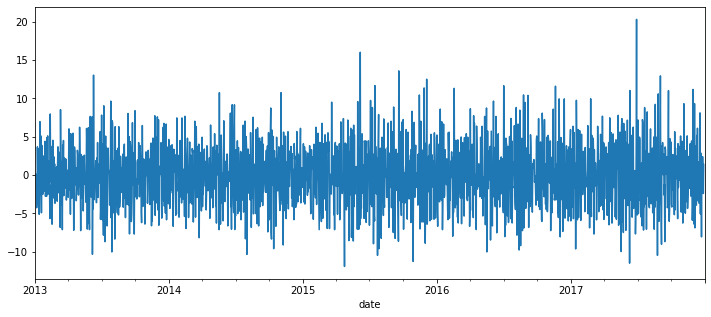

In [18]:
result.resid.plot(figsize = (12,5))

### Stationarity 

Time series forecasting presents an interesting problem. We know that regression works the best when our variables are not collinear, meaning they are independent of each other, however, classic time series models rely on autocorrelation (discussed below - creating time lags of the target variable, meaning it's using its own past trends as predictors for the future) which by its very nature, means there will be collinearity. We can tell if this will be a problem for our model by looking at its stationarity. A series is said to be stationary when it does not show trend or seasonality - meaning it should look just like our residual plot above; like noise. When a data set is stationary, we can't tell how one point relates to another based on a point in time. For the reasons discussed above, time series models often require data to be stationary in order to make accurate predictions. When your data is not stationary, it will need to be transformed before the model can make predictions. It's often hard to tell if your data is stationary or not just by looking at a chart. Often more advanced statistical methods such as the Dickey-Fuller Test need to be performed. The Dickey-Fuller test returns a p-value which, as a general rule, if the value is less than or equal 0.05, the data is said to be stationary. However, many statisticians agree that the p-value should be less than or equal to 0.01 in order to achieve better model performance. Let's run the Dickey-Fuller test to take a look at our stationarity. 

In [119]:
adfuller(store_1['sales'].dropna(),autolag='AIC')

(-3.1576705563327927,
 0.022569380626572252,
 23,
 1802,
 {'1%': -3.4339840952648695,
  '5%': -2.8631452508003057,
  '10%': -2.567624583142913},
 10896.776833317934)

The second item from the output above is the p-value (0.02257). Our p-value is less than 0.05, but not less than or equal to 0.01. This means our data could possibly stand to be differenced. Differencing our data essentially takes our target variable and shifts it up one row, and then subtracts the target variable from the new shifted variable. Doing this removes trends and seasonality. Sometimes, differencing once is not enough to remove trends and seasonality and so it needs to be done multiple times until there is no trend or pattern in the data. I will demonstrate this below, starting with the original plot of sales.  

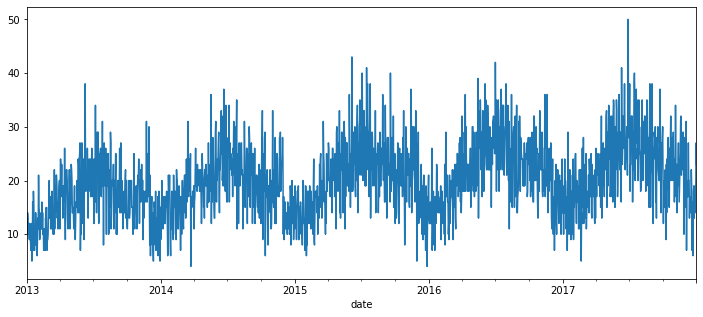

In [126]:
store_1['sales'].plot(figsize = (12,5))

In looking at the above chart, we can see some seasonality and perhaps a hint of trend as well, meaning this data is currently non-stationary. To make it more stationary, we can difference it once and see if all trends and patterns have been removed. If there are still trends and patterns we can difference again and again until they have been removed.

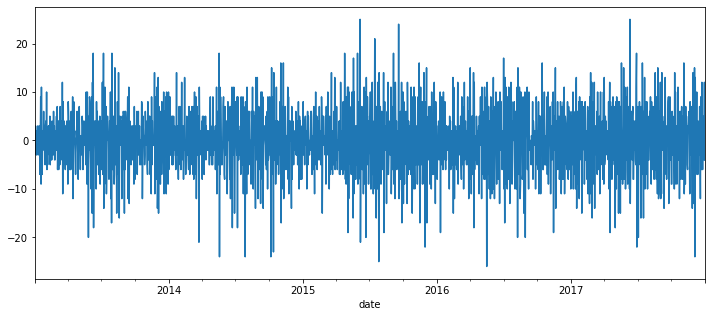

In [124]:
diff(store_1['sales'], k_diff = 1).plot()

Looking at the chart above, it looks like this data is adequately stationary. To be certain, let's run the Dickey-Fuller one more time on our differenced data: 

In [127]:
adfuller(diff(store_1['sales'], k_diff = 1))

(-12.676793886047596,
 1.210927632042978e-23,
 22,
 1802,
 {'1%': -3.4339840952648695,
  '5%': -2.8631452508003057,
  '10%': -2.567624583142913},
 10899.545399393755)

Notice how the p-value is now 1.2e-12. The p-value is so low it is basically zero, which indicates that we only needed to difference our data once to achieve stationarity. The number of differences we performed will be a key input into our predictive model.

### Autocorrelation and Partial Autocorrelation

Autocorrelation and partial autocorrelation are advanced statistics topics, so we won't deep dive into the math at this point, but will instead provide a high level understanding of each term (see this [link](https://people.duke.edu/~rnau/411arim3.htm) if you are interested in the more technical side of this). Autocorrelation, like correlation, measures the strength of a relationship between two variables. However, where correlation measures the strength of a linear relationship between two *different* variables, autocorrelation measures the linear relationship between "lagged values" of the time series data. So if we have T (for time) we would measure the relationship between T and T-1 (one unit of time - i.e. hour, day, month).  When time series data is strongly autocorrelated, previous values in the time series data can be helpful in predicting future values. Partial autocorrelation is a bit more complicated. "The partial autocorrelation function is a measure of the correlation between observations of a time series that are separated by k time units (yt and yt–k), after adjusting for the presence of all the other terms of shorter lag (yt–1, yt–2, ..., yt–k–1)" - [Source - Minitab.com](https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/time-series/how-to/partial-autocorrelation/interpret-the-results/partial-autocorrelation-function-pacf/). It is in the analysis and use of both of these plots that we can determine if our data is more autoregressive in nature, or contains more moving average compenents, or both. An important item to note when doing this analysis is that **the data must be stationary**. As our data wasn't completely stationary, we will difference it as part of our call for each plot to investigate the autocorrelation and partial autocorrelation. We'll first look at the autocorrelation of our data set.

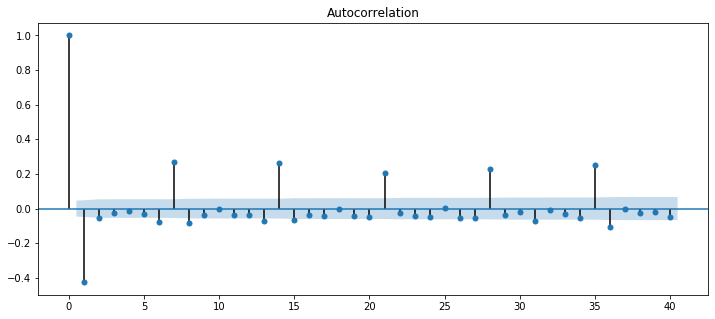

In [129]:
plot_acf(diff(store_1['sales'], k_diff = 1), lags= 40);

As a general rule of thumb provided by an often sited Duke University publication, "If the ACF of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA term to the model. The lag at which the ACF cuts off is the indicated number of MA terms" - [Duke.edu](https://people.duke.edu/~rnau/411arim3.htm). In looking at our plot above, we can see that at lag one the autocorrelation is negative, meaning that we should consider adding moving average terms to our predictive model, and as the drop off occurred at lag one, we would start by considering just one term. Let's now turn our attention to the partial autocorrelation plot.

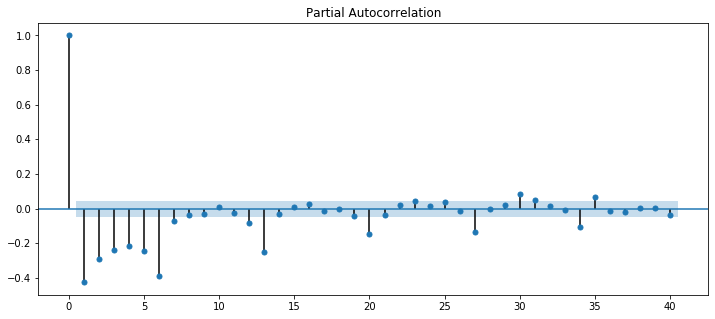

In [128]:
plot_pacf(diff(store_1['sales'], k_diff = 1), lags= 40);

Again, Duke has another helpful rule. "If the PACF of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive--i.e., if the series appears slightly "underdifferenced"--then consider adding an AR term to the model. The lag at which the PACF cuts off is the indicated number of AR terms"- [Duke.edu](https://people.duke.edu/~rnau/411arim3.htm). In our plot we have a sharp cutoff on the first lag, although it isn't positive. The wording says "and/or" and also mentions that if we see this we can "consider" adding an AR term to our model. As the drop off occurred at lag one, we would consider adding one autoregressive term. 

As you can see from the wording and the plots above, interpreting these plots can be difficult and is often more of a starting point than actually providing hard and fast values to plug into your time series model. That's why in practice, you'll most often see people use an automated method to find these values through a grid search. The grid search will cycle through different values for each parameter and will "converge" on the optimized values for the model. Below we will use a grid search function called auto_arima. 

### Preliminary Model using Auto_ARIMA to find Order Values

Now, all of our analysis will begin to pay off. The `auto_arima()` function takes in a series of time series data as well as an argument to tell the grid search algorithm whether our data has a seasonal component or not. We saw earlier that our data has a weekly seasonality, so we say "True" here. Lastly, `m` is asking for the "number of observations per seasonal cycle" - [alkaline-ml.com](https://alkaline-ml.com/pmdarima/tips_and_tricks.html). We saw that our seasonal cycle was weekly and there are 7 observations in each week, so we will set m to 7. 

In [130]:
import warnings # to hide harmless warnings
warnings.filterwarnings('ignore')

auto_arima(store_1['sales'], seasonal= True, m = 7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1826
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -5415.497
Date:                             Fri, 08 May 2020   AIC                          10844.995
Time:                                     23:22:45   BIC                          10883.560
Sample:                                          0   HQIC                         10859.221
                                            - 1826                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.659e-06      0.000     -0.013      0.990      -0.000       0.000
ar.L1         -0.7875      0.191     -4.123      0.000      -1.162      -0.413
ma.L1         -0.0822      0.181     -0.454      0.650      -0.437       0.273
ma.L2         -0.7286      0.159     -4.582      0.000      -1.040      -0.417
ar.S.L7        0.9991      0.001    882.284      0.000       0.997       1.001
ma.S.L7       -0.9841      0.008   -116.506      0.000      -1.001      -0.968
sigma2        21.7482      0.666     32.648      0.000      20.443      23.054
===================================================================================
Ljung-Box (Q):                       44.19   Jarque-Bera (JB):                23.98
Prob(Q):                              0.30   Prob(JB):                         0.00
Heteroskedasticity (H):               1.32   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Running the grid search above returned the following model: SARIMAX(1, 1, 2)x(1, 0, 1, 7). In looking at this output, the three numbers in the first set of parentheses are the numbers we were trying to estimate with our analysis above. The first number is the AR term, and we had decided based on the plot to enter a one for this term, which is also what the grid search returned. The second value is how many times the data was differenced to achieve stationarity. We differenced the data once to reach stationarity. The third number is the moving average term. For this term, we would consider entering one based on our plots, but based on the grid search, it looks like 2 moving average terms may be more appropriate. The other four number in the second set of parentheses relate to the seasonal component of the model. The first three numbers relate to the same information as the three numbers from the first set of parentheses, only the autoregressive order, difference order, and moving average order are specifically only looking at the seasonal elements of the data. The fourth element is our `m` value which is the number of observations per seasonal cycle.  	

Now that we have the orders for our SARIMAX model, let's run a preliminary model so we can set a benchmark before we do any feature engineering. In order to test our model, we'll need to create a training and a holdout data set. The holdout data set will not be part of the training data, so we can test our model on "unseen" data. We'll create this split with some simple indexing. 

In [139]:
train = store_1[:'2017-09-30']
test = store_1['2017-10-01':]

First we'll call SARIMAX and enter our orders, then we'll fit the model. 

In [151]:
model = SARIMAX(train['sales'], order=(1, 1, 2), seasonal_order=(1, 0, [1], 7), enforce_invertibility= False).fit()

In [152]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               sales   No. Observations:                 1734
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -5136.315
Date:                             Fri, 08 May 2020   AIC                          10284.630
Time:                                     23:59:45   BIC                          10317.376
Sample:                                 01-01-2013   HQIC                         10296.741
                                      - 09-30-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9993      0.020    -49.386      0.000      -1.039      -0.960
ma.L1          0.1027     16.211      0.006      0.995     -31.669      31.875
ma.L2         -0.8973     14.546     -0.062      0.951     -29.407      27.613
ar.S.L7        0.9999      0.000   3182.183      0.000       0.999       1.000
ma.S.L7       -0.9906      0.008   -124.919      0.000      -1.006      -0.975
sigma2        21.7089    352.276      0.062      0.951    -668.740     712.158
===================================================================================
Ljung-Box (Q):                       41.79   Jarque-Bera (JB):                30.48
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Next, we'll use our model to generate some predictions and then plot those predictions on the same plot as the holdout data set. 

In [153]:
start = len(train)
end = len(train) + len(test) - 1

predictions = model.predict(start, end, typ = 'levels').rename("General Model: No Exogenous Variables")

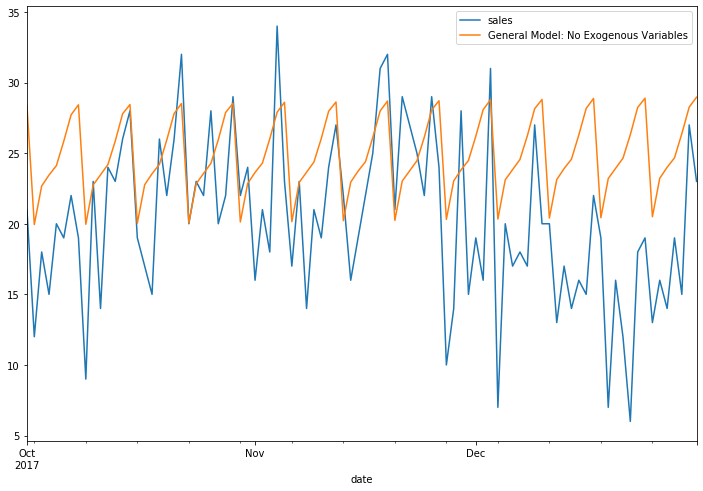

In [154]:
test['sales'].plot(legend = True, figsize = (12,8))
predictions.plot(legend = True)

In [157]:
print("The RMSE is {}".format(rmse(test['sales'], predictions)))

The RMSE is 6.9623975615888325


In [158]:
print("The MEAN of our sales is {}".format(test['sales'].mean()))

The MEAN of our sales is 20.22826086956522


As you can see from the plot above, our model isn't doing too well. It's definitely picking up the weekly seasonality, but that's about it. Our RMSE is 6.9, where the mean of our sales is only 20.22. That being said, our model is not very accurate. I also ran the model that we would have determined had we not used auto_arima and it was only slightly less accurate. SARIMAX is capable of also taking in exogenous variables, hence the 'X' at the end of the name. In an attempt to make our model more accurate, let's see if we can add some predictive features with some feature engineering. 

### Feature Engineering

As I mentioned at the beginning of this project, when working with a training and test data set, it is critical that you perform the same data transformations on both data sets. As such, we combined both data sets and indicated on each row whether it related to the training or test data set. 

We will start by creating some lag features as well as some features using the `rolling()` function in Pandas to create rolling averages, median values, and exponentially weighted means. In order to create these features, we will need to make sure that our data frame is sorted by date, store, and item. 

In [448]:
df.sort_values(by=['store','item','date'], axis=0, inplace=True)

One tricky piece to all this is that we can only create predictive features that can also be included in the test set. The test set is 90 days of data, so when we do lag features or rolling window features, we need to make sure we offset the data to start 91 days before the current date so that when we get to the 90th day in the test set, the rolling and lag features still have the last day of the training set to look at for its calculations. 

In [449]:
#Creating lag features. These features just return the data from the lagged time period, i.e. 91, 98, 105 days ago.

df['lag_91'] = df.groupby(['store', 'item'])['sales'].shift(periods = 91)
df['lag_98'] = df.groupby(['store', 'item'])['sales'].shift(periods = 98)
df['lag_105'] = df.groupby(['store', 'item'])['sales'].shift(periods = 105)
df['lag_112'] = df.groupby(['store', 'item'])['sales'].shift(periods = 112)
df['lag_119'] = df.groupby(['store', 'item'])['sales'].shift(periods = 119)
df['lag_126'] = df.groupby(['store', 'item'])['sales'].shift(periods = 126)
df['lag_133'] = df.groupby(['store', 'item'])['sales'].shift(periods = 133)
df['lag_140'] = df.groupby(['store', 'item'])['sales'].shift(periods = 140)
df['lag_147'] = df.groupby(['store', 'item'])['sales'].shift(periods = 147)
df['lag_154'] = df.groupby(['store', 'item'])['sales'].shift(periods = 154)
df['lag_161'] = df.groupby(['store', 'item'])['sales'].shift(periods = 161)
df['lag_168'] = df.groupby(['store', 'item'])['sales'].shift(periods = 168)
df['lag_175'] = df.groupby(['store', 'item'])['sales'].shift(periods = 175)
df['lag_182'] = df.groupby(['store', 'item'])['sales'].shift(periods = 182)
df['lag_364'] = df.groupby(['store', 'item'])['sales'].shift(periods = 364)


#Creating rolling mean and median features

df['rolling_182_mean'] = df.groupby(['store', 'item'])['sales'].shift(periods = 91).rolling(window = 91).mean()
df['rolling_182_median'] = df.groupby(['store', 'item'])['sales'].shift(periods = 91).rolling(window = 91).median()
df['rolling_364_mean'] = df.groupby(['store', 'item'])['sales'].shift(periods = 91).rolling(window = 182).mean()
df['rolling_364_median'] = df.groupby(['store', 'item'])['sales'].shift(periods = 91).rolling(window = 182).median()


#Creating exponentially weighted average features

df['ewa_91_mean'] = df.groupby(['store', 'item'])['sales'].shift(periods = 91).ewm(span= 12).mean()
df['ewa_182_mean'] = df.groupby(['store', 'item'])['sales'].shift(periods = 182).ewm(span= 12).mean()
df['ewa_365_mean'] = df.groupby(['store', 'item'])['sales'].shift(periods = 364).ewm(span= 12).mean()


Additionally, we'll create some features related to the date.

In [450]:
df['date'] = df.index
df['dom'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['dow'] = df['date'].dt.dayofweek
#f_df['weekofyear'] = f_df['date'].dt.weekofyear
df['is_month_start'] = (df['date'].dt.is_month_start).astype(int)
df['is_month_end'] = (df['date'].dt.is_month_end).astype(int)
df.drop('date', axis = 1, inplace = True)

In [451]:
df = pd.get_dummies(df, columns=['dom', 'month', 'dow'])

Utilizing our strategy outlined above, we'll run our new features over store 1 item 1 before broadcasting to the full population.

In [276]:
store1 = df[(df['store']==1) & (df['item']==1) & (df['train_or_test']=="TRAIN")]
store1.index.freq = 'D'
store1.dropna(subset = ['lag_364'], inplace = True)
store1.isnull().sum()

store               0
item                0
sales               0
train_or_test       0
id               1462
                 ... 
dow_2               0
dow_3               0
dow_4               0
dow_5               0
dow_6               0
Length: 79, dtype: int64

Now that we've created our new data set `store1` that contains all our new features, we'll create another train and test set to test our model. 

In [277]:
train = store1[:'2017-09-30']
test = store1['2017-10-01':]

This time in our call to SARIMAX, we'll include the `exog` argument and pass in our new feature columns. We can get the names of our new columns by calling the `.columns` attribute.

In [278]:
train.columns

Index(['store', 'item', 'sales', 'train_or_test', 'id', 'lag_91', 'lag_98',
       'lag_105', 'lag_112', 'lag_119', 'lag_126', 'lag_133', 'lag_140',
       'lag_147', 'lag_154', 'lag_161', 'lag_168', 'lag_175', 'lag_182',
       'lag_364', 'rolling_182_mean', 'rolling_182_median', 'rolling_364_mean',
       'rolling_364_median', 'ewa_91_mean', 'ewa_182_mean', 'ewa_365_mean',
       'is_month_start', 'is_month_end', 'dom_1', 'dom_2', 'dom_3', 'dom_4',
       'dom_5', 'dom_6', 'dom_7', 'dom_8', 'dom_9', 'dom_10', 'dom_11',
       'dom_12', 'dom_13', 'dom_14', 'dom_15', 'dom_16', 'dom_17', 'dom_18',
       'dom_19', 'dom_20', 'dom_21', 'dom_22', 'dom_23', 'dom_24', 'dom_25',
       'dom_26', 'dom_27', 'dom_28', 'dom_29', 'dom_30', 'dom_31', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'dow_0',
       'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6'],
      dtype='object')

### SARIMAX with Exogenous Variables

In [398]:
model2 = SARIMAX(train['sales'], order=(1, 0, 1), seasonal_order=(2, 0, [1], 7), exog= train[['lag_91', 'lag_98',
       'lag_105', 'lag_112', 'lag_119', 'lag_126', 'lag_133', 'lag_140',
       'lag_147', 'lag_154', 'lag_161', 'lag_168', 'lag_175', 'lag_182',
       'lag_364', 'rolling_182_mean', 'rolling_182_median', 'rolling_364_mean',
       'rolling_364_median', 'ewa_91_mean', 'ewa_182_mean', 'ewa_365_mean',
       'is_month_start', 'is_month_end', 'dom_1', 'dom_2', 'dom_3', 'dom_4',
       'dom_5', 'dom_6', 'dom_7', 'dom_8', 'dom_9', 'dom_10', 'dom_11',
       'dom_12', 'dom_13', 'dom_14', 'dom_15', 'dom_16', 'dom_17', 'dom_18',
       'dom_19', 'dom_20', 'dom_21', 'dom_22', 'dom_23', 'dom_24', 'dom_25',
       'dom_26', 'dom_27', 'dom_28', 'dom_29', 'dom_30', 'dom_31', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'dow_0',
       'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6']], enforce_invertibility= False, enforce_stationarity=False).fit()

In [399]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             sales   No. Observations:                 1370
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 7)   Log Likelihood               -3931.371
Date:                           Sat, 09 May 2020   AIC                           8022.741
Time:                                   02:31:54   BIC                           8439.666
Sample:                               12-31-2013   HQIC                          8178.851
                                    - 09-30-2017                                         
Covariance Type:                             opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
lag_91                 0.0005      0.034      0.014      0.989      -0.067       0.068
lag_98                -0.0385      0.031     -1.259      0.208      -0.098       0.021
lag_105                0.0338      0.028      1.221      0.222      -0.020       0.088
lag_112                0.0111      0.029      0.388      0.698      -0.045       0.067
lag_119               -0.0003      0.029     -0.011      0.991      -0.057       0.057
lag_126                0.0208      0.028      0.740      0.459      -0.034       0.076
lag_133               -0.0010      0.029     -0.035      0.972      -0.058       0.056
lag_140               -0.0601      0.030     -2.004      0.045      -0.119      -0.001
lag_147                0.0303      0.029      1.052      0.293      -0.026       0.087
lag_154               -0.0457      0.029     -1.559      0.119      -0.103       0.012
lag_161               -0.0632      0.029     -2.182      0.029      -0.120      -0.006
lag_168               -0.0135      0.028     -0.482      0.630      -0.068       0.041
lag_175             5.452e-05      0.031      0.002      0.999      -0.060       0.060
lag_182               -0.0419      0.034     -1.235      0.217      -0.108       0.025
lag_364                0.0167      0.035      0.480      0.631      -0.051       0.085
rolling_182_mean       0.6638      0.441      1.505      0.132      -0.201       1.529
rolling_182_median    -0.7432      0.292     -2.548      0.011      -1.315      -0.172
rolling_364_mean       0.6363      0.486      1.310      0.190      -0.316       1.589
rolling_364_median    -0.1399      0.391     -0.358      0.721      -0.907       0.627
ewa_91_mean            0.1457      0.128      1.140      0.254      -0.105       0.396
ewa_182_mean          -0.0770      0.127     -0.605      0.545      -0.326       0.172
ewa_365_mean           0.2126      0.095      2.243      0.025       0.027       0.398
is_month_start         0.5668      0.345      1.644      0.100      -0.109       1.243
is_month_end          -0.2285      1.347     -0.170      0.865      -2.869       2.412
dom_1                  0.5668      0.345      1.644      0.100      -0.109       1.243
dom_2                 -0.2217      0.782     -0.284      0.777      -1.754       1.311
dom_3                  2.3027      0.795      2.895      0.004       0.744       3.861
dom_4                  1.0023      0.647      1.549      0.121      -0.266       2.271
dom_5                  1.9948      0.663      3.010      0.003       0.696       3.294
dom_6                  1.5136      0.722      2.095      0.036       0.098       2.929
dom_7                  0.4851      0.923      0.526      0.599      -1.324       2.294
dom_8                  0.2813      0.718      0.392      0.695      -1.126       1.689
dom_9                  1.7169      0.794      2.163      0.031       0.161       3.272
dom_10    

In [400]:
start = len(train)
end = len(train) + len(test) - 1

predictions2 = model2.predict(start, end, exog= test[['lag_91', 'lag_98',
       'lag_105', 'lag_112', 'lag_119', 'lag_126', 'lag_133', 'lag_140',
       'lag_147', 'lag_154', 'lag_161', 'lag_168', 'lag_175', 'lag_182',
       'lag_364', 'rolling_182_mean', 'rolling_182_median', 'rolling_364_mean',
       'rolling_364_median', 'ewa_91_mean', 'ewa_182_mean', 'ewa_365_mean',
       'is_month_start', 'is_month_end', 'dom_1', 'dom_2', 'dom_3', 'dom_4',
       'dom_5', 'dom_6', 'dom_7', 'dom_8', 'dom_9', 'dom_10', 'dom_11',
       'dom_12', 'dom_13', 'dom_14', 'dom_15', 'dom_16', 'dom_17', 'dom_18',
       'dom_19', 'dom_20', 'dom_21', 'dom_22', 'dom_23', 'dom_24', 'dom_25',
       'dom_26', 'dom_27', 'dom_28', 'dom_29', 'dom_30', 'dom_31', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'dow_0',
       'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6']], typ = 'levels').rename("SARIMAX: ALL Exogenous Variables")

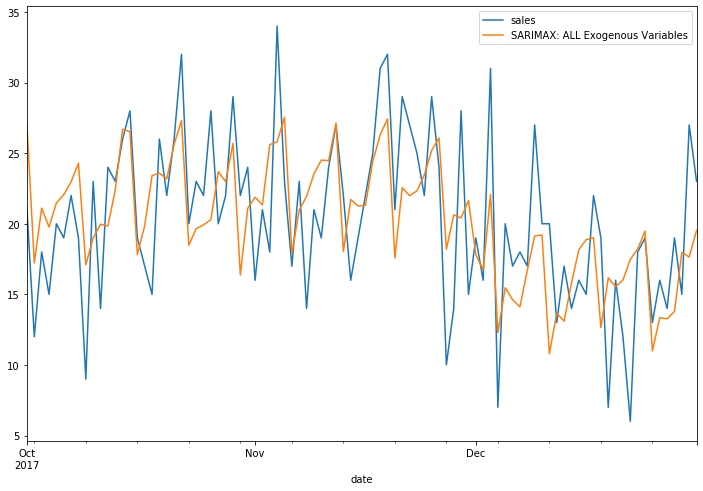

In [401]:
test['sales'].plot(legend = True, figsize = (12,8))
predictions2.plot(legend = True)

In [402]:
print("The RMSE is {}".format(rmse(test['sales'], predictions2)))

The RMSE is 4.6554039863831544


The model with the additional exogenous variables proved to be a better fit than our previous model. Additionally, I tried integrating holidays and other date factors to improve the RMSE score, but generally as I added more variables, the RMSE would increase. In an effort to simplify the model, I began removing columns using backward elimination, removing different combinations of columns until I reached the lowest RMSE. To bring the score down a little more, I also did some grid search for hyperparameters and found a different order set than had been suggested by auto_arima. The model below is the final model. 

### Final Model for Kaggle Competition

In [403]:
model1 = SARIMAX(train['sales'], order=(0, 0, 0), seasonal_order=(2, 0, [1], 7), exog= train[['rolling_182_mean', 'rolling_182_median','rolling_364_mean',
       'rolling_364_median',     
        'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'dow_0', 'dow_1',
       'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6']], enforce_invertibility= False, enforce_stationarity=False).fit()

In [404]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                     sales   No. Observations:                 1370
Model:             SARIMAX(2, 0, [1], 7)   Log Likelihood               -3964.466
Date:                   Sat, 09 May 2020   AIC                           7982.932
Time:                           02:42:07   BIC                           8123.664
Sample:                       12-31-2013   HQIC                          8035.624
                            - 09-30-2017                                         
Covariance Type:                     opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
rolling_182_mean       0.8317      0.377      2.207      0.027       0.093       1.570
rolling_182_median    -0.8677      0.272     -3.185      0.001      -1.402      -0.334
rolling_364_mean       1.1123      0.417      2.666      0.008       0.295       1.930
rolling_364_median    -0.6219      0.357     -1.743      0.081      -1.321       0.078
month_1               -3.4872      1.301     -2.680      0.007      -6.037      -0.937
month_2               -2.1148      1.250     -1.692      0.091      -4.565       0.335
month_3                1.0119      1.064      0.951      0.342      -1.073       3.097
month_4                5.2529      0.948      5.542      0.000       3.395       7.111
month_5                7.6298      0.816      9.353      0.000       6.031       9.229
month_6               10.6147      0.704     15.070      0.000       9.234      11.995
month_7               11.8178      0.602     19.618      0.000      10.637      12.998
month_8                8.0881      0.860      9.404      0.000       6.402       9.774
month_9                6.2808      1.129      5.565      0.000       4.069       8.493
month_10               3.4991      1.284      2.725      0.006       0.982       6.016
month_11               4.1092      1.324      3.104      0.002       1.514       6.704
month_12              -3.2659      1.329     -2.458      0.014      -5.870      -0.662
dow_0                  2.3148      1.448      1.598      0.110      -0.524       5.154
dow_1                  5.3080      1.452      3.656      0.000       2.462       8.154
dow_2                  5.7272      1.454      3.940      0.000       2.878       8.576
dow_3                  6.4302      1.444      4.454      0.000       3.601       9.260
dow_4                  8.3041      1.433      5.796      0.000       5.496      11.112
dow_5                 10.1545      1.423      7.136      0.000       7.365      12.944
dow_6                 11.1977      1.423      7.867      0.000       8.408      13.987
ar.S.L7                0.7993      0.099      8.105      0.000       0.606       0.993
ar.S.L14               0.0070      0.029      0.241      0.809      -0.050       0.064
ma.S.L7               -0.7823      0.097     -8.059      0.000      -0.973      -0.592
sigma2                20.1785      0.748     26.969      0.000      18.712      21.645
===================================================================================
Ljung-Box (Q):                       31.95   Jarque-Bera (JB):                24.63
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2]

In [405]:
start = len(train)
end = len(train) + len(test) - 1

predictions1 = model1.predict(start, end, exog= test[['rolling_182_mean', 'rolling_182_median','rolling_364_mean',
       'rolling_364_median',     
        'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'dow_0', 'dow_1',
       'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6']], typ = 'levels').rename("SARIMAX: Exogenous Variables")

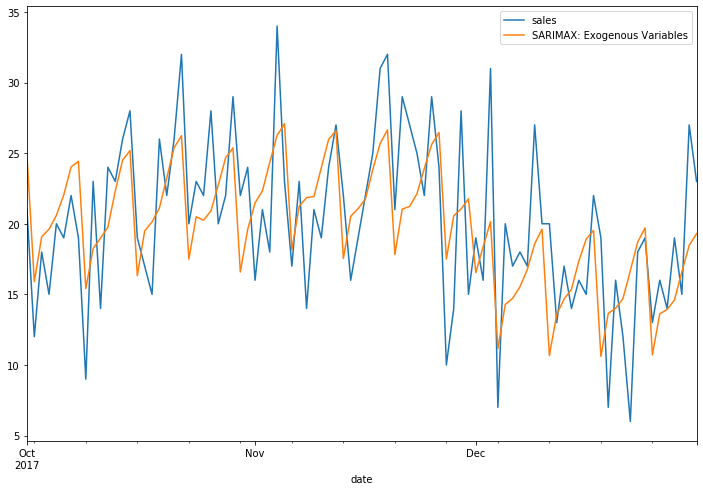

In [406]:
test['sales'].plot(legend = True, figsize = (12,8))
predictions1.plot(legend = True)

In [407]:
print("The RMSE is {}".format(rmse(test['sales'], predictions1)))

The RMSE is 4.509639353117337


This model has outperformed all other models, and while not an astoundingly accurate model, I would say it is an acceptable model. Our initial model run with no exogenous variables had a RMSE of 6.96. Our final model has a RMSE of 4.51, a decrease of 2.45 or 35%. 

The last step in this process is to apply this model to every item in every store. We can accomplish that with a for-loop. The for loop will be constructed in a way as to build the output as required for the Kaggle contest submission. We start with item 1 and loop through it daily sales in stores 1 through 10, and then move on to item two, and so on until all items have the appropriate forecast. 

In [488]:
final_results = pd.Series()

train_final = df[df['train_or_test'] == "TRAIN"]
train_final.dropna(subset = ['lag_364'], inplace = True)

test_final = df[df['train_or_test'] == "TEST"]

for item in range(1,51):
    for store in range(1,11):
        current_item = train_final[(train_final['store']==store) & (train_final['item']==item)]
        test_item = test_final[(test_final['store']==store) & (test_final['item']==item)]
        current_item.index.freq = 'D'
        test_item.index.freq = 'D'
        
        start = len(current_item)
        end = len(current_item) + len(test_item) - 1
        
        model_final = SARIMAX(current_item['sales'], order=(0, 0, 0), seasonal_order=(2, 0, [1], 7), 
            exog= current_item[['rolling_182_mean', 'rolling_182_median','rolling_364_mean', 'rolling_364_median',
            'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
            'month_10', 'month_11', 'month_12', 'dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6']],
            enforce_invertibility= False, enforce_stationarity=False).fit()
        
        predictions_final = model_final.predict(start, end, exog= test_item[['rolling_182_mean', 'rolling_182_median','rolling_364_mean',
       'rolling_364_median', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'dow_0', 'dow_1',
       'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6']], typ = 'levels')
        
        final_results = final_results.append(predictions_final)

csv = final_results.reset_index()
csv = csv.reset_index()
csv.rename(columns={'level_0':'id', 0:'sales'}, inplace=True)
csv.drop('index', axis = 1, inplace = True)

csv.to_csv(r'C:\Users\chris\OneDrive\Master Of Data Science - CUNY\Spring 2020\DATA607\Final Project - Time Series Forecasting\submission.csv', index = False )

The full code takes about 2 hours and 50 minutes to run. This Kaggle "Store Item Demand Forecasting Challenge" requires that submissions be entered through a Kaggle Kernel. This means that you can't just upload a CSV file for your submission, but you have to run your full code on their servers. To do this, I had to alter my code to a script format and use the data sets they provide through their API as opposed to the downloaded CSV files. The link to that code can be found [here](https://www.kaggle.com/christianthieme/attempt-2).

### Kaggle Results

For this competition, Kaggle uses a symmetric mean absolute percentage error (SMAPE) to rank your predictions against other competitors. Being a calculation of error, we would want the smallest SMAPE possible. The top ranked submission has a SMAPE of 12.58015 and the lowest ranked submission has a SMAPE of 150.95610. I received a score of 14.81081, which is only 2.231% off of the best score. Overall, I'm very pleased with the accuracy of my final model and happy to see that it received similar results to those who used more popular algorithms like xgboost. The script used in my submission as well as a summary of my score can be found [here](https://www.kaggle.com/christianthieme/attempt-2). 

### Conclusion and Next Steps

Time series modeling is a highly statistical and complex area of predictive modeling and while I only scratched the surface here, I was able to learn a tremendous amount about time series data as well as get an introduction to the underlying statistics that these classic models rely on and run under the hood. This project provided an excellent opportunity to learn about working with the complexities of time series data as well as the best ways to visualize it for analysis. It also provided the exciting opportunity to enter my first Kaggle competition. 

For the next steps here, I would love to extend this modeling exercise and try out xgboost or a neural network to see what kind of accuracy increases we would see. Additionally, based on how the item and store data didn't vary much from item to item or store to store, there are other techniques that could have been used and explored to drive these predictions. It would be interesting to see if other higher level methods prove more accurate than the individual item at each individual store approach I took. 